# Revisão do artigo “Model-independent quantum phases classifier”

In [30]:
import numpy as np
import pandas as pd
import utils
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier


## Modelos Físicos

Foram usados os hamiltonianos a seguir

- cadeias XXZ com anisotropia de ion uniaxial ($H_1$), dado por:

$$\mathcal{H_1} = \sum^N_{l=1}[J(S_l^xS_{l+1}^x + S^y_lS^y_{l+1}) + J_zS_l^zS_{l+1}^z] + D \sum^N_{l=1}S_l^{z2} $$

Onde $S_l$ é o operador spin-1 agindo sobre o sítio $l$ de uma cadeia de $N$ sítios. D representa a anisotropia de ion único e $J=1, J_z$ são os acoplamentos entre os spins. O diagrama de fase desse sistema contém: Haldane, Large D, XY1, XY2, Ferromagnético e Néel.

- cadeia de vínculo alternante XXZ ($H_2$). O Hamiltoniano é dado por: 

$$\mathcal{H_2} = \sum^N_{l=1}\left[1-\delta(-1)^l\right](S_l^xS_{l+1}^x + S^y_lS^y_{l+1} + \Delta S_l^zS_{l+1}^z) $$

Aqui, $\Delta$ representa a força a anisotropia de Ising da interação spin órbita no material magnético. Já  o termo $\delta$ representa o vínculo alternante que descreve dimerização.

Tal sistema apresenta fase ferromagnéica, XX1, Néel, Haldane e Dimerizada.

- Cadeia biquadrática linear ($H_3$), dada por

$$\mathcal{H_2} = \sum^N_{l=1}[\cos \theta (S_l S_{l+1}) + \sin\theta (S_l S_{l+1})]$$

com $\theta \in [0,2\pi)$ representa o vínculo entre vizinhos. Esse modelo apresenta Haldane, Trimerizado, Ferromagnético e Dimerizado.

### Implementação do modelos

Os modelos foram implementados no arquivo `hamiltonians.py`, usando POO. Os modelos são construídos baseados em uma classe `Hamiltonian`.

### Parâmetros dos modelos:

Os parâmetros utilizados no modelo estão a seguir

## Correladores

Os modelos foram implementados no arquivo `correlators.py`, usando POO. A ideia de deixar separado do hamiltoniano é para não precisarmos inicializar os correladores caso não queiramos mudar o número de spin.

Os correladores são da forma $\langle S_1^k S_i^k \rangle$  para $i \in [1, N/2 + 1]$, $k \in [x,y,z]$ e $\left\langle \prod_j S_j^k \right\rangle$ para $j \in [1, N]$


## Coleta de dados

A coleta de dados é feita através do `data_generation.py`.

## ML Phase Classifier

### We need to assign the labels to each value

Thanks to Mahlow for that

In [31]:
phases = ['Haldane', 'Trimer', 'Ferro', 'Dimer',
          'LD', 'XY1', 'Neel', 'XY2']
colors = ['red', 'purple', 'blue', 'green', 'yellow',
           'cyan', 'olive', 'black']

phase_color = {phases[i]: colors[i] for i in range(len(phases))}

In [32]:
df_H1_theorical = pd.read_csv('data/theoretical/XXZ.csv', header=None)
df_H2_theorical = pd.read_csv('data/theoretical/bond-alternating.csv', header=None)
df_H3_theorical = pd.DataFrame([0.25, 0.5, 1.25, 1.75])

In [ ]:
def assign_labels(dfs_corr: dict[str, pd.DataFrame]):
    phases = ['Haldane', 'Trimer', 'Ferro', 'Dimer',
          'LD', 'XY1', 'Neel', 'XY2']
    
    # labels XXZ correlations
    H1_labels = []
    for i in range(0, len(dfs_corr['H1'])):
        x = dfs_corr['H1'].values[i, 0]
        y = dfs_corr['H1'].values[i, 1]

        # Ferro/LD phases
        if x < -1.8375250:
            if y < (-0.1009)*(x**2) - 1.6701*x - 1.329:
                H1_labels.append(2)
            else:
                H1_labels.append(4)

        # Ferro/XY phases
        elif x >= -1.837525 and x < -0.278:
            if y >-0.0741*x**3 - 0.3014*x**2 - 0.872*x + 0.3499:
                H1_labels.append(4)
            elif y < -5.1127*x**5 - 27.865*x**4 - 57.426*x**3 - 55.858*x**2 - 27.638*x - 6.4824:
                H1_labels.append(2)
            else:
                H1_labels.append(5)

        elif x >= -0.278 and x < 0:
            if y >-0.0741*x**3 - 0.3014*x**2 - 0.872*x + 0.3499:
                H1_labels.append(4)
            elif y < -5.1127*x**5 - 27.865*x**4 - 57.426*x**3 - 55.858*x**2 - 27.638*x - 6.4824:
                H1_labels.append(2)
            elif y < 4.595*x**2 + 1.393*x - 2.007:
                H1_labels.append(7)
            else:
                H1_labels.append(5)

        # LD/Haldane phases
        elif x >= 0 and x < 3.28405:
            if y > 0.0807*x**2 + 0.5418*x + 0.3465:
                H1_labels.append(4)
            elif y > -0.0462*x**3 + 0.154*x**2 + 1.5213*x - 2.0196:
                H1_labels.append(0)
            else:
                H1_labels.append(6)

        # LD/Neel phases
        elif x >= 3.28405 and x <= 4:
            if y > 1.0906*x - 0.583:
                H1_labels.append(4)
            else:
                H1_labels.append(6)

    dfs_corr['H1']["labels"]= [phases[i] for i in H1_labels]
    
    ######################################################################
    # labels Bond correlations
    H2_labels = []
    for i in range(0, len(dfs_corr['H2'])):
        x = dfs_corr['H2'].values[i, 0]
        y = dfs_corr['H2'].values[i, 1]
        

        # Ferro phases
        if x < -1:
            H2_labels.append(2)

        # XY/Dimer phases
        elif x >= -1 and x < 0:
            if y > 0.1435*x**2 - 0.6447*x + 0.2197:
                H2_labels.append(3)
            else:
                H2_labels.append(5)

        # HALDANE/DIMER
        elif x >= 0 and x < 1:
            if y > 0.0043*x**3 - 0.0384*x**2 + 0.0631*x + 0.2317:
                H2_labels.append(3)
            else:
                H2_labels.append(0)   

        # Haldane/Neel phases
        elif x >= 1.0 and x <= 1.2:
            if y > -0.0872*x**2 + 0.6067*x - 0.2264:
                H2_labels.append(3)
            elif y > -247.1*x**3 + 826.12*x**2 - 921.85*x + 343.48:
                H2_labels.append(6)
            else:
                H2_labels.append(0)

        # Neel/Dimmer phases
        elif x > 1.2 and x <= 2.5:
            if y > -0.0872*x**2 + 0.6067*x - 0.2264:
                H2_labels.append(3)
            else:
                H2_labels.append(6)

    dfs_corr['H2']["labels"]= [phases[i] for i in H2_labels]

    ######################################################################
    # Labels bilinear
    H3_labels = []
    
    for i in range(0, len(dfs_corr['H3'])):
        # Haldane phases
        if dfs_corr['H3'].values[i,0] <= 0.25*np.pi and dfs_corr['H3'].values[i,0] >= 0 or dfs_corr['H3'].values[i,0] > 1.75*np.pi and dfs_corr['H3'].values[i,0] <= 2*np.pi:
            H3_labels.append(0)
        # Trimer phases
        elif dfs_corr['H3'].values[i,0] > 0.25*np.pi and dfs_corr['H3'].values[i,0] <= 0.5*np.pi:
            H3_labels.append(1)
        # Ferro phases
        elif dfs_corr['H3'].values[i,0] > 0.5*np.pi and dfs_corr['H3'].values[i,0] <= 1.25*np.pi:
            H3_labels.append(2)
        # Dimer phases
        else:
            H3_labels.append(3)

    dfs_corr['H3']["labels"]= [phases[i] for i in H3_labels]
    

In [ ]:
def read_correlations(N: int) -> dict[str, pd.DataFrame]:
    dfs_corr = {
    }
    for i in range(1,4):
        dfs_corr[f'H{i}'] = pd.read_csv(f'data/H{i}/N={N}_art.csv')
        dfs_corr[f'H{i}']['knn'] =  np.empty(dfs_corr[f'H{i}'].shape[0])
    
    assign_labels(dfs_corr)
    
    # Normalization, if done, must happen AFTER this point

    return dfs_corr

dfs_corr = read_correlations(12)

### Gráfico do PCA das correlações

In [35]:
def PCA_transform(df):
    pca = PCA(2)

    X_train = df.values[:,2:-3]
    X_train = Normalizer().fit_transform(X_train)
    # X_train= utils.SpatialSignScaling(X_train)
    y_train = df.values[:,-1]

    im_size = 6

    pca_result = pca.fit_transform(X_train)
    classes = np.unique(y_train)
    plt.figure(figsize=(im_size,im_size))
    for c in classes:
        nodes = np.where(y_train == c)
        plt.scatter(pca_result[nodes,0], pca_result[nodes,1], s=50/8*im_size, color = phase_color[c], 
                    label = c)
    plt.legend()
    plt.xlabel("First component", fontsize=20/8*im_size)
    plt.ylabel("Second component", fontsize=20/8*im_size)
    plt.xticks(color='k', size=20/8*im_size)
    plt.yticks(color='k', size=20/8*im_size)
    plt.show()


#### H3

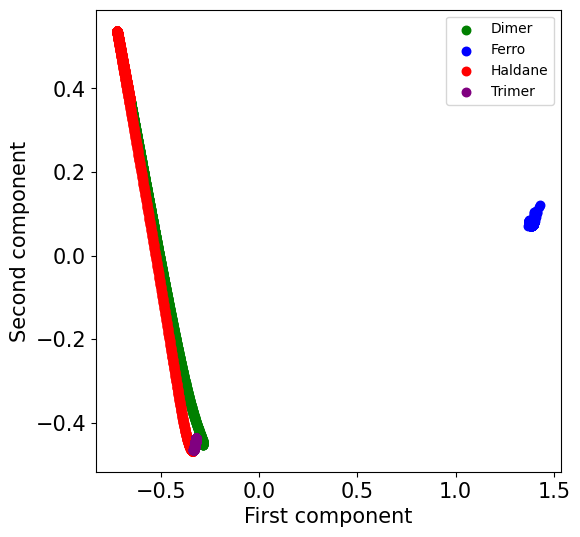

In [ ]:
PCA_transform(dfs_corr['H3'])


#### H2

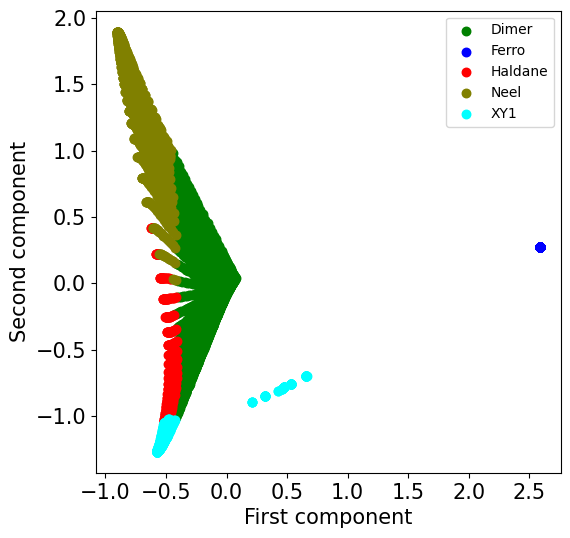

In [ ]:
PCA_transform(dfs_corr['H2'])

#### H1

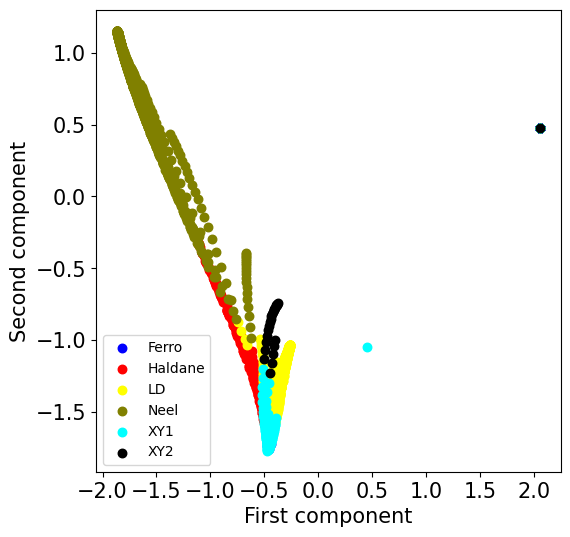

In [ ]:
PCA_transform(dfs_corr['H1'])

## Using KNN to classify the quantum phases


In [ ]:
def classify(dfs_corr: dict[str, pd.DataFrame], test_key: str, ignored_phases: list[str] = []):
    train_keys = list(dfs_corr.keys())
    train_keys.remove(test_key)
 
    
    # Gets used in the KNN

    X = None
    y = None
    for key in train_keys:
        df_key = dfs_corr[key] 
        X_key = Normalizer().fit_transform(df_key.values[:,2:-2])
        y_key = df_key.values[:,-1]
        
        if (X is None): X = X_key;
        else: X = np.vstack((X,X_key))
        if (y is None): y = y_key;
        else: y = np.hstack((y,y_key))

    # Gets X_prev and Y prev
    df_test = dfs_corr[test_key][
        ~dfs_corr[test_key]['labels'].isin(ignored_phases)
        ]


    X_test = Normalizer().fit_transform(df_test.values[:,2:-2])
    y_test = df_test.values[:,-1]


    knn = KNeighborsClassifier(50)
    knn.fit(X, y) # type: ignore
    
    X_pred = Normalizer().fit_transform(dfs_corr[test_key].values[:,2:-2])
    dfs_corr[test_key]['knn'] = knn.predict(X_pred)
    print(f"{test_key} prediction score: {knn.score(X_test, y_test)}")

classify(dfs_corr, 'H3', ['Trimer'])
classify(dfs_corr, 'H2')
classify(dfs_corr, 'H1', ['LD', 'XY1'])

H3 prediction score: 0.7327202610501334
H2 prediction score: 0.68296875
H1 prediction score: 0.9760532150776053


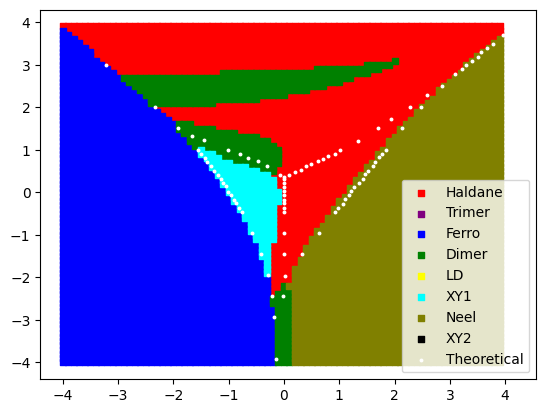

In [ ]:
df = dfs_corr['H1']
for phase in phases:
    phase_data = df[df['knn'] == phase]
    plt.scatter(phase_data['Jz'], phase_data[' D'], s=13, marker= 's', label = phase, color = phase_color[phase])
plt.scatter(df_H1_theorical[0], df_H1_theorical[1], s=13, marker= '.', label = 'Theoretical', color = 'white')
plt.legend()

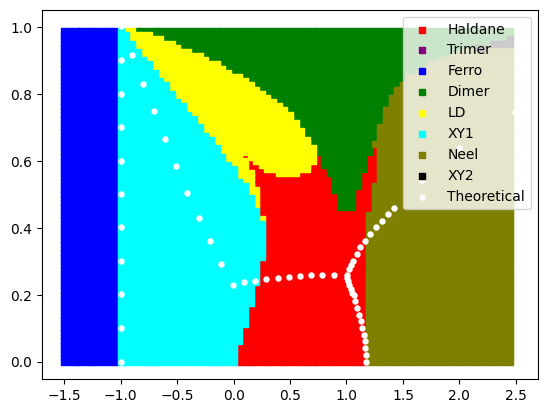

In [ ]:
df = dfs_corr['H2']
for phase in phases:
    phase_data = df[df['knn'] == phase]
    plt.scatter(phase_data['Delta'], phase_data[' delta'], s=13, marker= 's', label = phase, color = phase_color[phase])
plt.scatter(df_H2_theorical[0], df_H2_theorical[1], s=13, marker= 'o', label = 'Theoretical', color = 'white')

plt.legend()

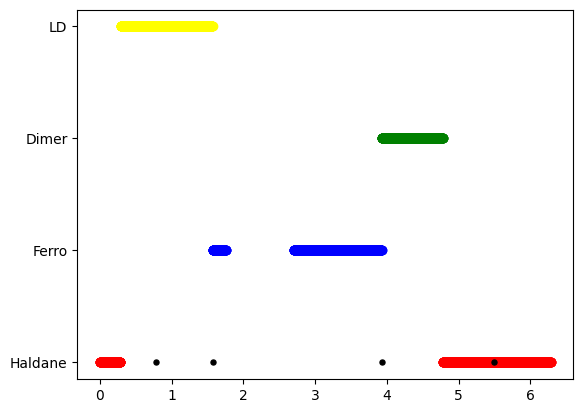

In [ ]:
df = dfs_corr['H3']
for phase in phases:
    phase_data = df[df['knn'] == phase]
    plt.scatter(phase_data['theta'],phase_data['knn'], label = phase, color = phase_color[phase])

plt.scatter(df_H3_theorical[0]*np.pi, np.zeros(4), s=13, marker= 'o', label = 'Theoretical', color = 'black')

